# 07 Modelling-Multiple linear Regression


Work book summary:

In this work book I take the results from the Arimax model as it performed better than the Prophet model and create a feature to feed into a Mulitple linear regression model. The aim is to see if that can help improve the predictions of the model using these predictions.

I also looked at the coefficients from the model to see if it was using the predictions. It was an important feature but it wasnt the most important one,.

I choose 3 regularisation patterns Ridge, Lasso and elasticnet and picked elasticnet

The results were:

Marubuzo:
+ Accuracy:	    0.5
+ Precision:    0.55
+ Recall:       0.67


Fractals:
+ Accuracy:	    0.72
+ Precision:	0.84
+ Recall:		0.72

The fractals patterns precision has improved well.

---

# Contents

- [1.0 About MLR](#1.0-About-MLR)
- [2.0 Marubozu](#2.0-Marubozu])
    - [2.1 Load Data](#2.1-Load-Data)
    - [2.2 Create Features list](#2.2-Create-Features-list)
    - [2.3 Check correlation](#2.3-Check-correlation)
    - [2.4 Train/Test Split](#2.4-Train/Test-Split)
    - [2.5 Model](#2.5-Model)
    - [2.6 Interprete Model](#2.6-Interprete-Model)
    - [2.7 Create Confusion Matrix](#2.7-Create-Confusion-Matrix)
- [3.0 Fractals](#3.0-Fractals)
    - [3.1 Load Data](#3.1-Load-Data)
    - [3.2 Create Features list](#3.2-Create-Features-list)
    - [3.3 Check correlation](#3.3-Check-correlation)
    - [3.4 Train/Test Split](#3.4-Train/Test-Split)
    - [3.5 Model](#3.5-Model)
    - [3.6 Interprete Model](#3.6-Interprete-Model)
    - [3.7 Create Confusion Matrix](#3.7-Create-Confusion-Matrix)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') 
%matplotlib inline
import datetime
# import calendar

from sklearn.metrics import r2_score, mean_squared_error
# import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from statsmodels.tools.eval_measures import rmse


In [2]:
pd.set_option('display.max_columns', None)

---

# 1.0  Model

I have chosen to use Multiple Linear Regression to predict the price of the next 5 time frames using several regularisation penalty terms.


+ Lasso - Quickly brings the coefficients down to 0 when they are not used in the model


+ Ridge - penalises high coefficients and reduces the impact of that feature on the model


+ ElasticNet - this uses a ratio of both ridge and lasso and L2 which can provide the best of both

---

# 2.0 Marubozu

## 2.1 Load Data

#### EUR/USD

In [3]:
# read in the daily data
daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usddailyMarubozu.csv', 
                    index_col='date', parse_dates=True)

In [4]:
daily.head()

,open,high,low,close,mid,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,height,height-1,height-2,height-3,direction,gold_usd,gold_euro,marubozu,marubozu+1,marubozu-1,marubozu-2,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+2_low,day+3_high,day+3_low,day+4_high,day+4_low,day+5_high,day+5_low,exit_price,select,target,date+5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-14,0.9353,0.9389,0.9318,0.9383,0.93680,0.94522,0.948145,0.003250,0.003387,-0.016431,-0.014102,-0.017514,0.0030,0.0062,0.0086,0.0041,1.0,97.4,122.0,0,0.0,-1.0,-1.0,0.9416,0.9503,0.9545,0.9425,0.9517,0.9569,0.9330,0.9396,0.9496,0.9354,0.9417,0.9504,0.9382,0.9402,0.9342,0.9360,0.9368,0.9227,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9413,0,0.9402,2000-07-21
2000-07-17,0.9382,0.9402,0.9342,0.9360,0.93710,0.94217,0.947100,0.004282,0.003440,-0.009408,-0.016013,-0.014875,0.0022,0.0030,0.0062,0.0086,-1.0,98.1,123.3,0,-1.0,0.0,-1.0,0.9353,0.9416,0.9503,0.9389,0.9425,0.9517,0.9318,0.9330,0.9396,0.9383,0.9354,0.9417,0.9361,0.9368,0.9227,0.9256,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9338,0,0.9193,2000-07-24
2000-07-18,0.9361,0.9368,0.9227,0.9256,0.93085,0.93785,0.945633,0.003582,0.003797,-0.008151,-0.022678,-0.020519,0.0105,0.0022,0.0030,0.0062,-1.0,98.3,123.8,-1,0.0,0.0,0.0,0.9382,0.9353,0.9416,0.9402,0.9389,0.9425,0.9342,0.9318,0.9330,0.9360,0.9383,0.9354,0.9255,0.9270,0.9193,0.9246,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9151,0,0.9193,2000-07-25
2000-07-19,0.9255,0.9270,0.9193,0.9246,0.92505,0.93366,0.944207,0.003915,0.003618,-0.012543,-0.022146,-0.029125,0.0009,0.0105,0.0022,0.0030,-1.0,97.0,123.3,0,1.0,-1.0,0.0,0.9361,0.9382,0.9353,0.9368,0.9402,0.9389,0.9227,0.9342,0.9318,0.9256,0.9360,0.9383,0.9245,0.9342,0.9204,0.9325,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9237,0,0.9204,2000-07-26
2000-07-20,0.9245,0.9342,0.9204,0.9325,0.92850,0.93166,0.943221,0.005881,0.004167,-0.009177,-0.010655,-0.024531,0.0080,0.0009,0.0105,0.0022,1.0,97.1,123.3,1,0.0,0.0,-1.0,0.9255,0.9361,0.9382,0.9270,0.9368,0.9402,0.9193,0.9227,0.9342,0.9246,0.9256,0.9360,0.9324,0.9384,0.9319,0.9365,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.9405,0,0.9450,2000-07-27


In [5]:
daily.shape

(4612, 51)

#### Results from the arima model

In [6]:
strat_res_mb = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/model_results/arima_results_mb.csv', 
                           parse_dates=True)

In [7]:
strat_res_mb.tail()

,name,strategy,date,time_frame,RMSE,MSE,classification
59,arima-0-1-0,marubozu,2018-09-17,daily,0.004317,0.000019,tp
60,arima-0-1-0,marubozu,2018-10-22,daily,0.012050,0.000145,fn
61,arima-0-1-0,marubozu,2018-12-10,daily,0.008124,0.000066,fn
62,arima-0-1-0,marubozu,2019-01-31,daily,0.009717,0.000094,fn
63,arima-0-1-0,marubozu,2019-02-13,daily,0.002301,0.000005,tn


In [8]:
len(strat_res_mb)

64

#### Marubozu

In [9]:
daily_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/patterns/dailyMarubozu.csv', 
                           parse_dates=True)
daily_pattern.head()

,pattern_end
0,2000-10-11
1,2000-10-20
2,2001-04-05
3,2001-04-09
4,2001-08-20


## 2.2 Create features list

In [10]:
features = daily[daily.index.isin(daily_pattern['pattern_end'])]
features.shape

(64, 51)

In [11]:
features = features[features.index.isin(strat_res_mb['date'])]
features.shape

(64, 51)

In [12]:
# Add Arima results as a feature to the dataset
results_series = list(strat_res_mb['classification'])
features['ml_signal'] = results_series
features.head()

,open,high,low,close,mid,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,height,height-1,height-2,height-3,direction,gold_usd,gold_euro,marubozu,marubozu+1,marubozu-1,marubozu-2,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+2_low,day+3_high,day+3_low,day+4_high,day+4_low,day+5_high,day+5_low,exit_price,select,target,date+5,ml_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-10-11,0.8733,0.8764,0.8644,0.8677,0.87050,0.87046,0.869214,0.001513,0.001716,0.000632,-0.006392,-0.014491,0.0056,0.0053,0.0019,0.0003,-1.0,94.8,127.4,-1,0.0,1.0,0.0,0.8679,0.8699,0.8701,0.8747,0.8710,0.8743,0.8670,0.8665,0.8674,0.8732,0.8680,0.8698,0.8676,0.8682,0.8597,0.8628,0.8660,0.8530,0.8557,0.8462,0.8565,0.8480,0.8579,0.8327,0.8621,1,0.8327,2000-10-18,tp
2000-10-20,0.8471,0.8475,0.8351,0.8401,0.84360,0.84774,0.867864,0.002844,0.003502,-0.009801,-0.017985,-0.030289,0.0070,0.0071,0.0146,0.0053,-1.0,94.0,131.8,-1,0.0,1.0,-1.0,0.8401,0.8546,0.8493,0.8487,0.8579,0.8565,0.8383,0.8327,0.8480,0.8472,0.8400,0.8546,0.8402,0.8426,0.8345,0.8367,0.8400,0.8349,0.8389,0.8249,0.8325,0.8229,0.8446,0.8290,0.8331,1,0.8229,2000-10-27,tp
2001-04-05,0.9066,0.9091,0.8943,0.8967,0.90165,0.89036,0.901571,0.007044,0.006930,0.024369,0.020832,0.010988,0.0099,0.0100,0.0138,0.0054,-1.0,89.7,117.5,-1,1.0,1.0,1.0,0.8966,0.8829,0.8775,0.9080,0.8987,0.8837,0.8937,0.8821,0.8745,0.9066,0.8967,0.8829,0.8966,0.9051,0.8927,0.9034,0.9051,0.8947,0.8995,0.8868,0.8918,0.8814,0.8946,0.8840,0.8868,1,0.8814,2001-04-12,tp
2001-04-09,0.9035,0.9051,0.8947,0.8965,0.90000,0.89861,0.898467,0.001073,0.006785,-0.001775,0.022495,0.006937,0.0070,0.0068,0.0099,0.0100,-1.0,90.0,117.2,-1,-1.0,1.0,-1.0,0.8966,0.9066,0.8966,0.9051,0.9091,0.9080,0.8927,0.8943,0.8937,0.9034,0.8967,0.9066,0.8964,0.8995,0.8868,0.8898,0.8918,0.8814,0.8946,0.8840,0.8933,0.8891,0.8895,0.8834,0.8895,1,0.8814,2001-04-16,tp
2001-08-20,0.9178,0.9205,0.9113,0.9126,0.91520,0.91110,0.887862,0.002255,0.003879,0.005714,0.021771,0.039350,0.0052,0.0053,0.0031,0.0110,-1.0,96.1,123.7,-1,0.0,1.0,0.0,0.9124,0.9156,0.9045,0.9184,0.9203,0.9171,0.9105,0.9093,0.9034,0.9177,0.9125,0.9155,0.9125,0.9185,0.9082,0.9168,0.9242,0.9123,0.9170,0.9101,0.9169,0.9078,0.9125,0.9087,0.9074,1,0.9078,2001-08-27,tp


In [13]:
# See number of signals
features.groupby('direction').count()['open']

direction
-1.0    36
 1.0    28
Name: open, dtype: int64

In [14]:
# count number of signals
features.groupby('ml_signal').count()['open']

ml_signal
fn    27
fp     5
tn    18
tp    14
Name: open, dtype: int64

In [15]:
# convert the signal into -1 or plus one to denote success and the direction
def convert_signal(row):
    if row['ml_signal'] == 'tp':
        return row['direction']
    else:
        return 0

In [16]:
features['ml_signal'] = features.apply(convert_signal, axis=1)

In [17]:
# count number of signals
features.groupby('ml_signal').count()['open']

ml_signal
-1.0     7
 0.0    50
 1.0     7
Name: open, dtype: int64

---

## 2.3 Check Correlation

In [18]:
# Only look at important ones
corr_df = features.drop(['marubozu+1','day+1_open', 'day+1_high', 'day+1_low', 'day+1_close', 'day+2_high',
       'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high', 'day+4_low',
       'day+5_high', 'day+5_low', 'exit_price', 'select', 'date+5'], axis=1)


In [19]:
corr_df.head()

,open,high,low,close,mid,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,height,height-1,height-2,height-3,direction,gold_usd,gold_euro,marubozu,marubozu-1,marubozu-2,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,target,ml_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-10-11,0.8733,0.8764,0.8644,0.8677,0.87050,0.87046,0.869214,0.001513,0.001716,0.000632,-0.006392,-0.014491,0.0056,0.0053,0.0019,0.0003,-1.0,94.8,127.4,-1,1.0,0.0,0.8679,0.8699,0.8701,0.8747,0.8710,0.8743,0.8670,0.8665,0.8674,0.8732,0.8680,0.8698,0.8327,-1.0
2000-10-20,0.8471,0.8475,0.8351,0.8401,0.84360,0.84774,0.867864,0.002844,0.003502,-0.009801,-0.017985,-0.030289,0.0070,0.0071,0.0146,0.0053,-1.0,94.0,131.8,-1,1.0,-1.0,0.8401,0.8546,0.8493,0.8487,0.8579,0.8565,0.8383,0.8327,0.8480,0.8472,0.8400,0.8546,0.8229,-1.0
2001-04-05,0.9066,0.9091,0.8943,0.8967,0.90165,0.89036,0.901571,0.007044,0.006930,0.024369,0.020832,0.010988,0.0099,0.0100,0.0138,0.0054,-1.0,89.7,117.5,-1,1.0,1.0,0.8966,0.8829,0.8775,0.9080,0.8987,0.8837,0.8937,0.8821,0.8745,0.9066,0.8967,0.8829,0.8814,-1.0
2001-04-09,0.9035,0.9051,0.8947,0.8965,0.90000,0.89861,0.898467,0.001073,0.006785,-0.001775,0.022495,0.006937,0.0070,0.0068,0.0099,0.0100,-1.0,90.0,117.2,-1,1.0,-1.0,0.8966,0.9066,0.8966,0.9051,0.9091,0.9080,0.8927,0.8943,0.8937,0.9034,0.8967,0.9066,0.8814,-1.0
2001-08-20,0.9178,0.9205,0.9113,0.9126,0.91520,0.91110,0.887862,0.002255,0.003879,0.005714,0.021771,0.039350,0.0052,0.0053,0.0031,0.0110,-1.0,96.1,123.7,-1,1.0,0.0,0.9124,0.9156,0.9045,0.9184,0.9203,0.9171,0.9105,0.9093,0.9034,0.9177,0.9125,0.9155,0.9078,-1.0


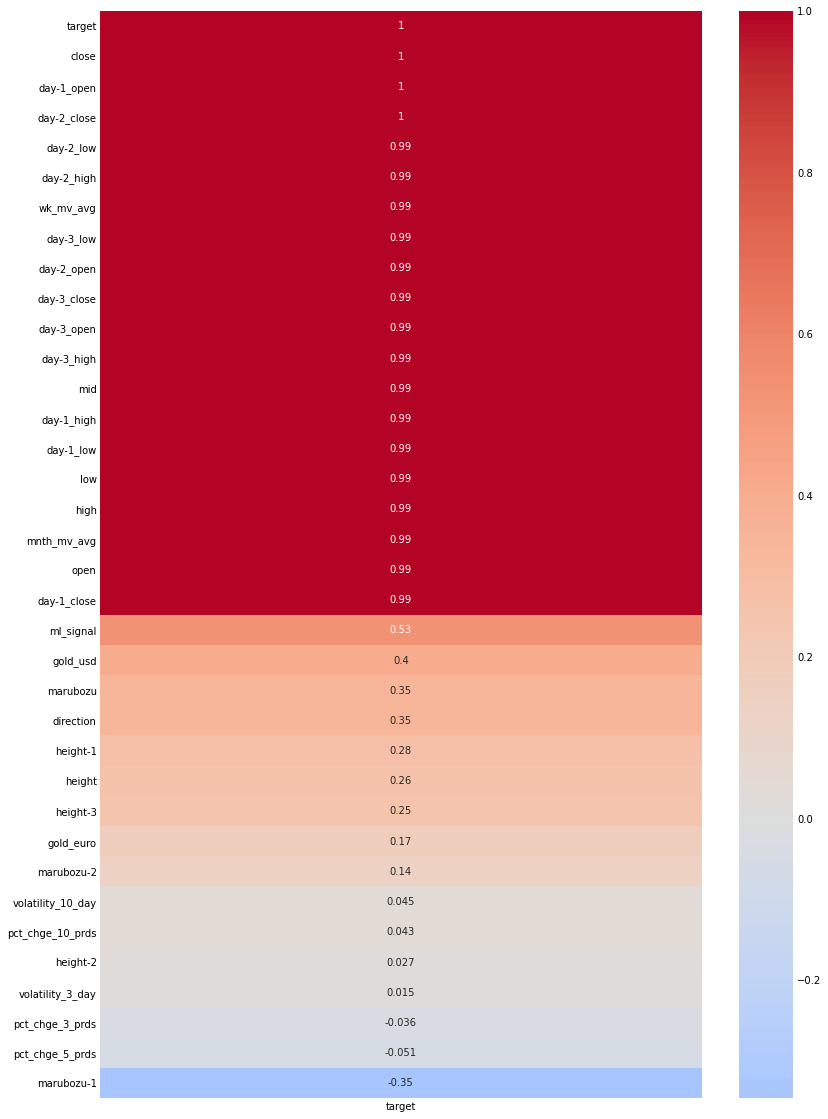

In [20]:
figure = plt.figure(figsize=(12,20))
sns.heatmap(corr_df.corr()[['target']].sort_values('target',ascending=False),annot=True, cmap='coolwarm', center=0);

A lot of the features are highly correlated - I will leave them in a let ridge and lasso penalties remove the unecessary featues. I will then go back and remove my own features. 

---

## 2.4 Train/Test Split

In [21]:
## Features and scaling

In [22]:
features.columns

Index(['open', 'high', 'low', 'close', 'mid', 'wk_mv_avg', 'mnth_mv_avg',
       'volatility_3_day', 'volatility_10_day', 'pct_chge_3_prds',
       'pct_chge_5_prds', 'pct_chge_10_prds', 'height', 'height-1', 'height-2',
       'height-3', 'direction', 'gold_usd', 'gold_euro', 'marubozu',
       'marubozu+1', 'marubozu-1', 'marubozu-2', 'day-1_open', 'day-2_open',
       'day-3_open', 'day-1_high', 'day-2_high', 'day-3_high', 'day-1_low',
       'day-2_low', 'day-3_low', 'day-1_close', 'day-2_close', 'day-3_close',
       'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close', 'day+2_high',
       'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high', 'day+4_low',
       'day+5_high', 'day+5_low', 'exit_price', 'select', 'target', 'date+5',
       'ml_signal'],
      dtype='object')

In [23]:
features_df = features.drop(['height-1', 'height-2',
       'height-3', 'marubozu',
       'marubozu+1', 'marubozu-1', 'marubozu-2', 'day-1_open', 'day-2_open',
       'day-3_open', 'day-1_high', 'day-2_high', 'day-3_high', 'day-1_low',
       'day-2_low', 'day-3_low', 'day-1_close', 'day-2_close', 'day-3_close',
       'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close', 'day+2_high',
       'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high', 'day+4_low',
       'day+5_high', 'day+5_low', 'exit_price', 'select', 'target', 'date+5'], axis=1)

In [24]:
X = features_df
y = features['target']

In [25]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=15)

In [26]:
#Standardize the data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# 2.5 Model

In [27]:
#I instantiate the various models
lr = LinearRegression()

lasso = LassoCV(n_alphas=200)

ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

enet = ElasticNetCV(l1_ratio=np.linspace(0.001, 1, 50), n_alphas = 100)

In [28]:
# Do cross validation

In [29]:
lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
lr_scores.mean()

0.9955833769501027

In [30]:
lasso_scores = cross_val_score(lasso, X_train_ss, y_train, cv=5)
lasso_scores.mean()

0.994823106651266

In [31]:
ridge_scores = cross_val_score(ridge, X_train_ss, y_train, cv=5)
ridge_scores.mean()

0.9951963106202358

In [32]:
enet_scores = cross_val_score(enet, X_train_ss, y_train, cv=5)
enet_scores.mean()

0.9948610161084593

Normal regression performed the best. However I will ue elasticnet as it was close and I feel it will generalise better on new datasets.

In [33]:
# Final run using the Test Data

In [34]:
# fit the model
enet.fit(X_train_ss, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=array([0.001     , 0.02138776, 0.04177551, 0.06216327, 0.08255102,
       0.10293878, 0.12332653, 0.14371429, 0.16410204, 0.1844898 ,
       0.20487755, 0.22526531, 0.24565306, 0.26604082, 0.28642857,
       0.30681633, 0.32720408, 0.34759184, 0.36797959, 0.38836735,
       0.4087551 , 0.42914286, 0.44953061, 0.46991837, 0.4...
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [35]:
# score the model on train
enet.score(X_train_ss, y_train)

0.9973777755480328

In [36]:
# score the model on unseen data
enet.score(X_test_ss, y_test)

0.9933414784502105

#### There is some overfitting but still generalised well

In [37]:
# Get predictions
yhat = enet.predict(X_test_ss)
r2_score(y_test, yhat)

0.9933414784502105

In [38]:
residuals = y_test - yhat

Text(0.5, 0, 'Predictions')

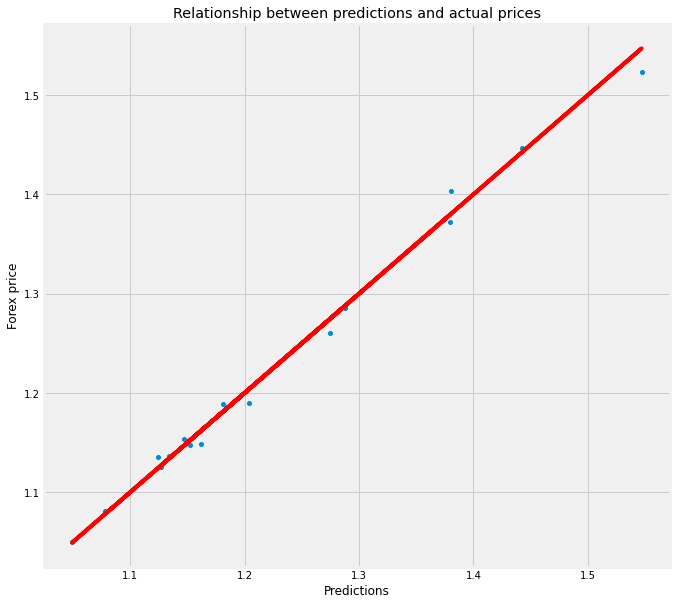

In [39]:
# Plot to show the correlation between prediction and value.
f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(y_test, yhat);
ax.plot(y_test.min(), y_test.max(),
        y_test, y_test, color='r');
plt.title("Relationship between predictions and actual prices") 
plt.ylabel("Forex price")
plt.xlabel("Predictions") 

The price predictions are visually quite accurate

Text(0.5, 0, 'Predictions')

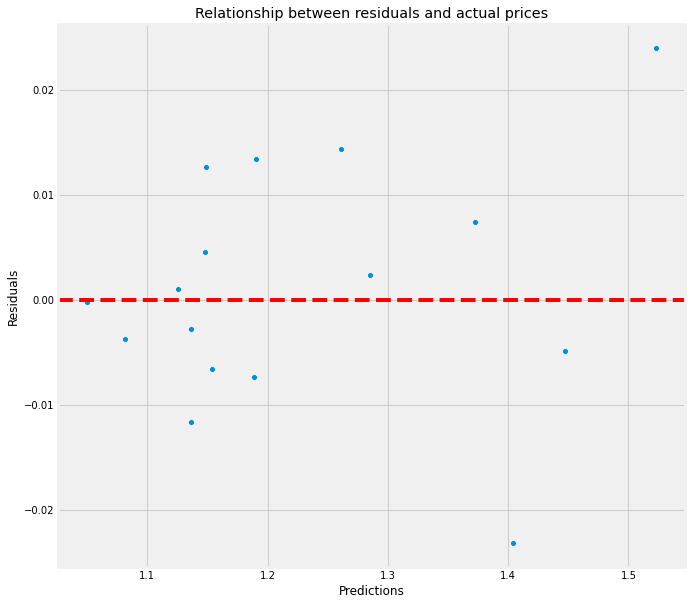

In [40]:
#plt.scatter(yhat, residuals);

f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(yhat, residuals);
ax.axhline(0, ls='--', color='r')
plt.title("Relationship between residuals and actual prices") 
plt.ylabel("Residuals")
plt.xlabel("Predictions")

The residuals are distributed evenly which is important

## 2.6 Interprete Model

In [41]:
# combine dataframes for analysis
model_coefs = pd.DataFrame(enet.coef_, index=X.columns)

model_coefs.rename(columns={0:'coef'}, inplace=True)
model_coefs.reset_index(inplace=True)
model_coefs.sort_values('coef',ascending=False, inplace=True)
model_coefs.rename(columns={'index':'feature'}, inplace=True)
model_coefs

,feature,coef
0,open,0.108149
1,high,0.036152
3,close,0.020952
13,direction,0.017402
11,pct_chge_10_prds,0.004407
16,ml_signal,0.004174
12,height,0.001287
15,gold_euro,0.000613
6,mnth_mv_avg,0.000000
5,wk_mv_avg,0.000000


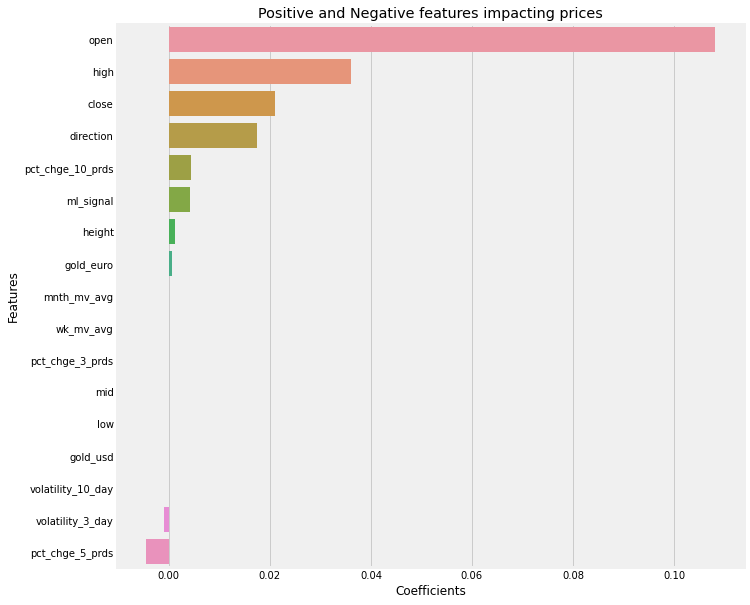

In [42]:
# Plot the graph to show top and bottom features.

f, ax = plt.subplots(figsize=(10,10))
sns.barplot(model_coefs['coef'],model_coefs['feature']);
plt.title("Positive and Negative features impacting prices") 
plt.ylabel("Features")
plt.xlabel("Coefficients") ;

## 2.7 Create Confusion Matrix

In [43]:
# add predictions
final_res_enet = X_test
final_res_enet['yhat'] = yhat
final_res_enet;

In [44]:
# filter dataframe
final_res_enet.sort_index(inplace=True)
final_res_enet[['open','high','low','close','yhat']].head()

,open,high,low,close,yhat
date,,,,,
2006-03-31,1.2159,1.2164,1.2066,1.2072,1.190058
2006-08-02,1.2830,1.2830,1.2743,1.2755,1.260746
2008-06-19,1.5570,1.5588,1.5468,1.5513,1.523050
2009-06-03,1.4304,1.4338,1.4109,1.4168,1.403645
2010-03-05,1.3589,1.3690,1.3529,1.3677,1.372100


In [45]:
# get the result dates
result_dates = final_res_enet.index

In [46]:
prepare_res = features.drop(['ml_signal','mid','wk_mv_avg', 'mnth_mv_avg',
       'volatility_3_day', 'volatility_10_day', 'pct_chge_3_prds',
       'pct_chge_5_prds', 'pct_chge_10_prds', 'height-1', 'height-2',
       'height-3', 'gold_usd', 'gold_euro', 'marubozu',
       'marubozu+1', 'marubozu-1', 'marubozu-2', 'day-1_open', 'day-2_open',
       'day-3_open', 'day-1_high', 'day-2_high', 'day-3_high', 'day-1_low',
       'day-2_low', 'day-3_low', 'day-1_close', 'day-2_close', 'day-3_close',
       'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close', 'day+2_high',
       'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high', 'day+4_low',
       'day+5_high', 'day+5_low', 'select', 'date+5'], axis=1)

In [47]:
# create the confusion matrix dataframe
create_cm_df = prepare_res.loc[prepare_res.index.isin(result_dates)]
create_cm_df;

In [48]:
# add predictions
create_cm_df['yhat'] = final_res_enet[['yhat']]
create_cm_df.rename(columns={'exit_price':'threshold','target':'actual_best'}, inplace=True)

In [49]:
def classify_row(row):
    
    if row['direction'] == -1:
        if row['actual_best'] <= row['threshold']:
            return 1
        else:
            return 0
    elif row['direction'] == 1:
        if row['actual_best'] >= row['threshold']:
            return 1
        else:
            return 0

In [50]:
def classify_mlr(row):
    
    if row['direction'] == -1:
        if row['yhat'] <= row['threshold']:
            return 1
        else:
            return 0
    elif row['direction'] == 1:
        if row['yhat'] >= row['threshold']:
            return 1
        else:
            return 0

In [51]:
create_cm_df['correct_decision'] = create_cm_df.apply(classify_row, axis=1)

In [52]:
create_cm_df['ml_decision'] = create_cm_df.apply(classify_mlr, axis=1)

In [53]:
def clasify_cm(row):
    if row['correct_decision'] == 1 and row['ml_decision'] ==1:
        return 'tp'
    elif row['correct_decision'] == 0 and row['ml_decision'] == 0:
        return 'tn'
    elif row['correct_decision'] == 0 and row['ml_decision'] == 1:
        return 'fp'
    elif row['correct_decision'] == 1 and row['ml_decision'] == 0:
        return 'fn'

In [54]:
create_cm_df['outcome'] = create_cm_df.apply(clasify_cm, axis=1)

In [55]:
def create_cm(enet_res):
    
    res_cm = [[0,0],
              [0,0]]
    
    for res in enet_res:
        if res == 'tp':
            res_cm[0][0] += 1
        elif res == 'fp':
            res_cm[0][1] += 1
        elif res == 'fn':
            res_cm[1][0] += 1
        elif res == 'tn':
            res_cm[1][1] += 1
    
    return res_cm

In [56]:
cm = create_cm(create_cm_df['outcome'])

In [57]:
cm_df = pd.DataFrame(cm, index=['pred_success', 'pred_non_success'], columns=['actual success', 'actual non_success'])
cm_df

,actual success,actual non_success
pred_success,6,5
pred_non_success,3,2


In [58]:
def print_metrics(cm):
    # Accuracy - how many did the model get right
    # Total number of correct predictions / total number of predictions
    acc= (cm[0][0]+cm[1][1])/(np.sum(cm))
    
    # Precision proportion of positive identifications that were actually correct
    # True positives/ true positives + false positives)
    prec = cm[0][0]/(cm[0][0]+cm[0][1])
    
    # Recall - proportion of actual positives that were correctly defined
    # True positives/ true positives + false negatives
    rec = cm[0][0]/(cm[0][0]+cm[1][0])

    print(f"Accuracy:\t{round(acc,2)}\nPrecision:\t{round(prec,2)}\nRecall:\t\t{round(rec,2)}")


In [59]:
# Display the results
print_metrics(cm)

Accuracy:	0.5
Precision:	0.55
Recall:		0.67


---

# 3.0 Fractals

## 3.1 Load Data¶

In [60]:
# read in the daily data
daily_fract = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usddailyfractals.csv', 
                    index_col='date', parse_dates=True)

In [61]:
daily_fract.head()

,open,high,low,close,mid,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,height,height-1,height-2,height-3,direction,gold_usd,gold_euro,day-1_high,day-2_high,day-3_high,day-4_high,day-1_low,day-2_low,day-3_low,day-4_low,day-1_open,day-2_open,day-3_open,day-4_open,day-1_close,day-2_close,day-3_close,day-4_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+2_low,day+3_high,day+3_low,day+4_high,day+4_low,day+5_high,day+5_low,5_day_avg,fractal_end,day+1_frac,day+2_frac,day+3_frac,day+4_frac,select,exit_price,target,date+5,fractal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-17,0.9382,0.9402,0.9342,0.9360,0.93710,0.94217,0.947100,0.004282,0.003440,-0.009408,-0.016013,-0.014875,0.0022,0.0030,0.0062,0.0086,0,98.1,123.3,0.9389,0.9425,0.9517,0.9569,0.9318,0.9330,0.9396,0.9496,0.9353,0.9416,0.9503,0.9545,0.9383,0.9354,0.9417,0.9504,0.9361,0.9368,0.9227,0.9256,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.00500,0,0.0,0.0,0.0,-1.0,0,0.93600,0.0000,2000-07-24,0
2000-07-18,0.9361,0.9368,0.9227,0.9256,0.93085,0.93785,0.945633,0.003582,0.003797,-0.008151,-0.022678,-0.020519,0.0105,0.0022,0.0030,0.0062,0,98.3,123.8,0.9402,0.9389,0.9425,0.9517,0.9342,0.9318,0.9330,0.9396,0.9382,0.9353,0.9416,0.9503,0.9360,0.9383,0.9354,0.9417,0.9255,0.9270,0.9193,0.9246,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.00610,0,0.0,0.0,-1.0,0.0,0,0.92560,0.0000,2000-07-25,0
2000-07-19,0.9255,0.9270,0.9193,0.9246,0.92505,0.93366,0.944207,0.003915,0.003618,-0.012543,-0.022146,-0.029125,0.0009,0.0105,0.0022,0.0030,0,97.0,123.3,0.9368,0.9402,0.9389,0.9425,0.9227,0.9342,0.9318,0.9330,0.9361,0.9382,0.9353,0.9416,0.9256,0.9360,0.9383,0.9354,0.9245,0.9342,0.9204,0.9325,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.00500,0,0.0,-1.0,0.0,0.0,0,0.92460,0.0000,2000-07-26,0
2000-07-20,0.9245,0.9342,0.9204,0.9325,0.92850,0.93166,0.943221,0.005881,0.004167,-0.009177,-0.010655,-0.024531,0.0080,0.0009,0.0105,0.0022,0,97.1,123.3,0.9270,0.9368,0.9402,0.9389,0.9193,0.9227,0.9342,0.9318,0.9255,0.9361,0.9382,0.9353,0.9246,0.9256,0.9360,0.9383,0.9324,0.9384,0.9319,0.9365,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.00500,0,-1.0,0.0,0.0,0.0,0,0.93250,0.0000,2000-07-27,0
2000-07-21,0.9324,0.9384,0.9319,0.9365,0.93445,0.93119,0.942879,0.006660,0.005033,0.003867,-0.002509,-0.016575,0.0041,0.0080,0.0009,0.0105,-1,97.1,122.2,0.9342,0.9270,0.9368,0.9402,0.9204,0.9193,0.9227,0.9342,0.9245,0.9255,0.9361,0.9382,0.9325,0.9246,0.9256,0.9360,0.9366,0.9367,0.9313,0.9330,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.9338,0.9229,0.00514,-1,0.0,0.0,0.0,0.0,1,0.93136,0.9229,2000-07-28,0


In [62]:
daily_fract.shape

(4632, 58)

In [63]:
# get fractal strategy results
strat_res_fr = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/model_results/arima_results_fr.csv', 
                           parse_dates=True)

In [64]:
strat_res_fr.tail(5)

,name,strategy,date,time_frame,RMSE,MSE,classification
607,arima-0-1-0,fractals,2019-10-03,daily,0.001674,0.000003,tn
608,arima-0-1-0,fractals,2019-10-23,daily,0.004562,0.000021,fp
609,arima-0-1-0,fractals,2019-11-18,daily,0.005665,0.000032,fn
610,arima-0-1-0,fractals,2019-11-20,daily,0.007602,0.000058,fp
611,arima-0-1-0,fractals,2019-12-16,daily,0.006449,0.000042,fp


In [65]:
len(strat_res_fr)

612

---

## 3.2 Create Features list

In [66]:
# get fractal pattern list
fractal_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/patterns/dailyfractals.csv', 
                           parse_dates=True)
fractal_pattern.head()

,pattern_end
0,2000-07-21
1,2000-07-28
2,2000-08-07
3,2000-08-22
4,2000-08-29


In [67]:
features_fr = daily_fract[daily_fract.index.isin(fractal_pattern['pattern_end'])]
features_fr.shape

(613, 58)

In [68]:
features_fr = features_fr[features_fr.index.isin(strat_res_fr['date'])]
features_fr.shape

(612, 58)

In [69]:
# add the arima signal to the data
results_series_fr = list(strat_res_fr['classification'])
features_fr['ml_signal'] = results_series_fr
features_fr;

In [70]:
# count number of features
features_fr.groupby('direction').count()['open']

direction
-1    314
 1    298
Name: open, dtype: int64

In [71]:
features_fr.groupby('ml_signal').count()['open']

ml_signal
fn    151
fp    116
tn     86
tp    259
Name: open, dtype: int64

In [72]:
def convert_signal(row):
    if row['ml_signal'] == 'tp':
        return row['direction']
    else:
        return 0

In [73]:
features_fr['ml_signal'] = features_fr.apply(convert_signal, axis=1)

In [74]:
features_fr.groupby('ml_signal').count()['open']

ml_signal
-1    110
 0    353
 1    149
Name: open, dtype: int64

---

---

## 3.3 Check correlation

In [75]:
corr_df_fr = features_fr.drop(['high', 'low', 'close', 'mid','height', 'height-1', 'height-2',
       'height-3', 'direction','day-1_high','day-1_close','day-1_low','day-1_open',
       'day-2_high', 'day-3_high', 'day-4_high', 'day-2_low',
       'day-3_low', 'day-4_low', 'day-2_open', 'day-3_open',
       'day-4_open', 'day-2_close', 'day-3_close',
       'day-4_close', 'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close',
       'day+2_high', 'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high',
       'day+4_low', 'day+5_high', 'day+5_low', 'fractal_end',
       'day+1_frac', 'day+2_frac', 'day+3_frac', 'day+4_frac', 'select',
       'exit_price', 'date+5', 'fractal'], axis=1)


In [76]:
corr_df_fr.head()

,open,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,gold_usd,gold_euro,5_day_avg,target,ml_signal
date,,,,,,,,,,,,,
2000-07-28,0.9320,0.93597,0.941517,0.008063,0.005738,-0.009605,-0.006849,-0.009340,96.6,122.4,0.00674,0.9295,0
2000-08-07,0.9090,0.91307,0.931095,0.004558,0.004815,-0.009052,-0.018472,-0.027974,94.9,122.7,0.00546,0.8965,-1
2000-08-22,0.9024,0.90927,0.915057,0.002085,0.005123,-0.019383,-0.014703,-0.007406,95.0,124.2,0.00500,0.9075,0
2000-08-29,0.8992,0.89958,0.906824,0.003953,0.004445,-0.004609,-0.001893,-0.016568,95.2,124.7,0.00520,0.9040,0
2000-09-04,0.9017,0.89552,0.903233,0.003867,0.004178,0.006656,-0.002052,-0.005691,96.1,125.5,0.00560,0.8571,-1


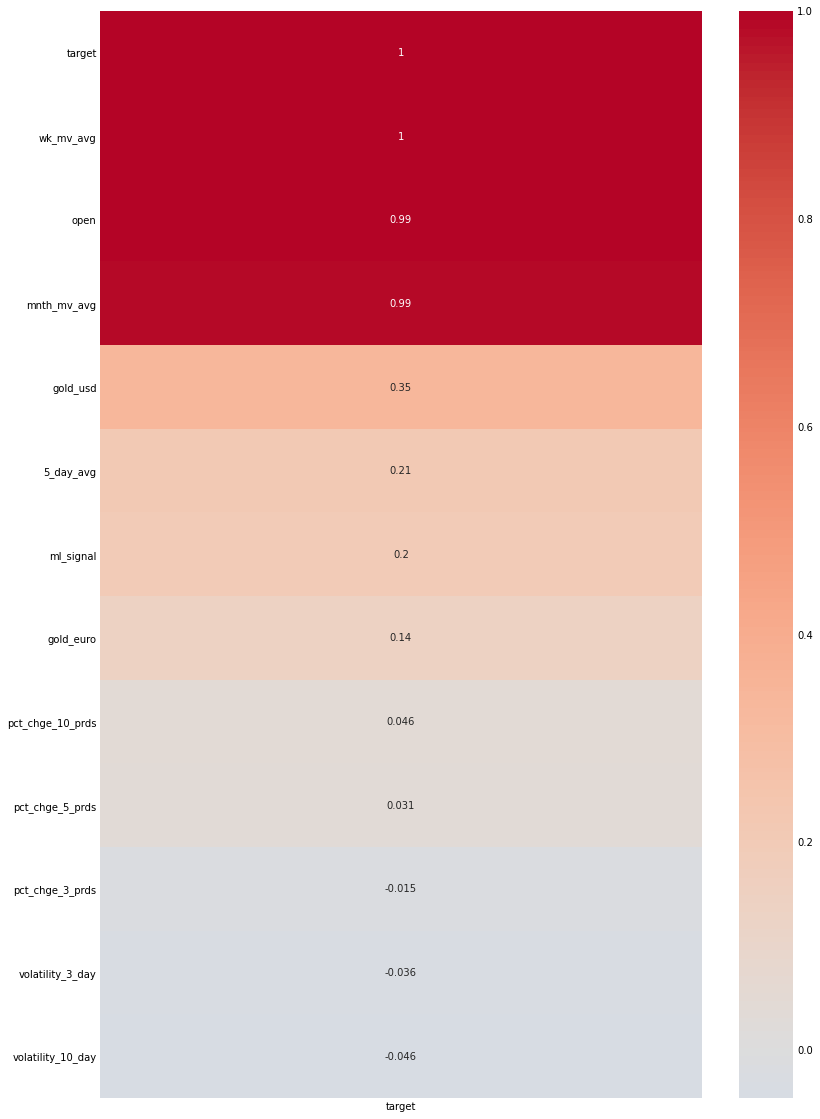

In [77]:
figure = plt.figure(figsize=(12,20))
sns.heatmap(corr_df_fr.corr()[['target']].sort_values('target',ascending=False),annot=True, cmap='coolwarm', center=0);

A lot of the features are highly correlated - I will leave them in a let ridge and lasso penalties remove the unecessary featues. I will then go back and remove my own features. 

---

## 3.4 Train/Test Split

In [78]:
## Features and scaling

In [79]:
features_df_fr = features_fr.drop(['mid','height', 'height-1', 'height-2',
       'height-3', 'direction','day-1_high','day-1_close','day-1_low','day-1_open',
       'day-2_high', 'day-3_high', 'day-4_high', 'day-2_low',
       'day-3_low', 'day-4_low', 'day-2_open', 'day-3_open',
       'day-4_open', 'day-2_close', 'day-3_close',
       'day-4_close', 'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close',
       'day+2_high', 'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high',
       'day+4_low', 'day+5_high', 'day+5_low', 'fractal_end',
       'day+1_frac', 'day+2_frac', 'day+3_frac', 'day+4_frac', 'select',
       'exit_price', 'date+5', 'fractal','target'], axis=1)

In [80]:
X = features_df_fr
y = features_fr['target']

In [81]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=15)

#Standardize data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# 3.5 Model

In [82]:
#I instantiate the various models
lr = LinearRegression()

lasso = LassoCV(n_alphas=200)

ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

enet = ElasticNetCV(l1_ratio=np.linspace(0.001, 1, 100), n_alphas = 100)

In [83]:
lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
lr_scores.mean()

0.9936025622785785

In [84]:
lasso_scores = cross_val_score(lasso, X_train_ss, y_train, cv=5)
lasso_scores.mean()

0.9930245789453565

In [85]:
ridge_scores = cross_val_score(ridge, X_train_ss, y_train, cv=5)
ridge_scores.mean()

0.99338830614736

In [86]:
enet_scores = cross_val_score(enet, X_train_ss, y_train, cv=5)
enet_scores.mean()

0.9929902216803935

lasso was best, but enet should be able to be tuned to beat it or at least match it.

In [87]:
enet.fit(X_train_ss, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=array([0.001     , 0.01109091, 0.02118182, 0.03127273, 0.04136364,
       0.05145455, 0.06154545, 0.07163636, 0.08172727, 0.09181818,
       0.10190909, 0.112     , 0.12209091, 0.13218182, 0.14227273,
       0.15236364, 0.16245455, 0.17254545, 0.18263636, 0.19272727,
       0.20281818, 0.21290909, 0.223     , 0.23309091, 0.24318182,...
       0.80827273, 0.81836364, 0.82845455, 0.83854545, 0.84863636,
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [88]:
enet.score(X_train_ss, y_train)

0.9938622950053597

In [89]:
enet.score(X_test_ss, y_test)

0.9948463731744758

In [90]:
yhat = enet.predict(X_test_ss)
r2_score(y_test, yhat)

0.9948463731744758

In [91]:
mse = (mean_squared_error(y_test, yhat))
print("The root mean squared error of the model is " + str(mse))

The root mean squared error of the model is 0.00012357153191568443


In [92]:
residuals = y_test - yhat

Text(0.5, 0, 'Predictions')

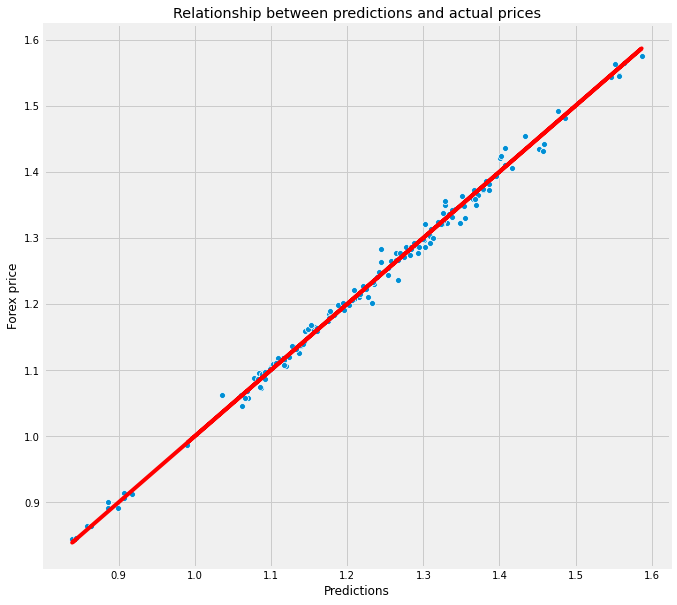

In [93]:
# Plot to show the correlation between prediction and value.
f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(y_test, yhat);
ax.plot(y_test.min(), y_test.max(),
        y_test, y_test, color='r');
plt.title("Relationship between predictions and actual prices") 
plt.ylabel("Forex price")
plt.xlabel("Predictions") 

The predicton and real values are visually look close. Small differences in the scale of data can be misleading though.

Text(0.5, 0, 'Predictions')

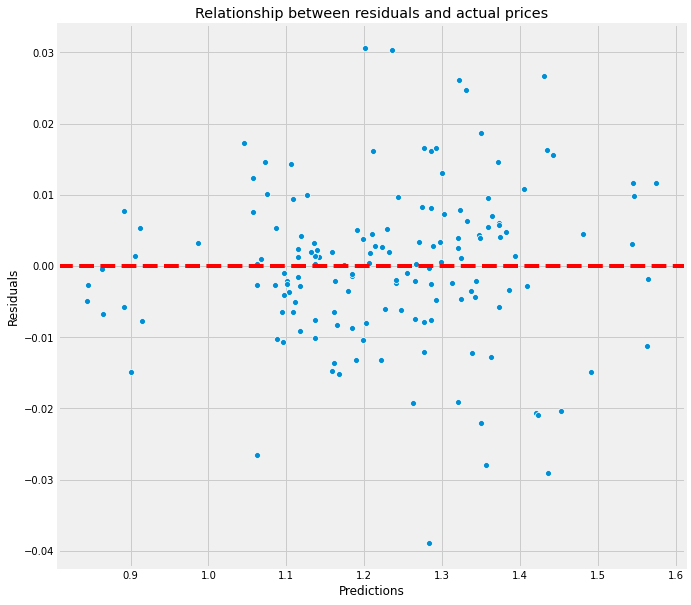

In [94]:
#plt.scatter(yhat, residuals);

f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(yhat, residuals);
ax.axhline(0, ls='--', color='r')
plt.title("Relationship between residuals and actual prices") 
plt.ylabel("Residuals")
plt.xlabel("Predictions")

The resisudals are spread out which is the correct sign.

---

## 3.6 Interprete Model

In [95]:
model_coefs = pd.DataFrame(enet.coef_, index=X.columns)

model_coefs.rename(columns={0:'coef'}, inplace=True)
model_coefs.reset_index(inplace=True)
model_coefs.sort_values('coef',ascending=False, inplace=True)
model_coefs.rename(columns={'index':'feature'}, inplace=True)
model_coefs

,feature,coef
3,close,0.075524
2,low,0.036556
1,high,0.027367
0,open,0.009266
14,ml_signal,0.008776
9,pct_chge_5_prds,0.005188
4,wk_mv_avg,0.001092
7,volatility_10_day,0.000301
10,pct_chge_10_prds,0.000071
5,mnth_mv_avg,0.000000


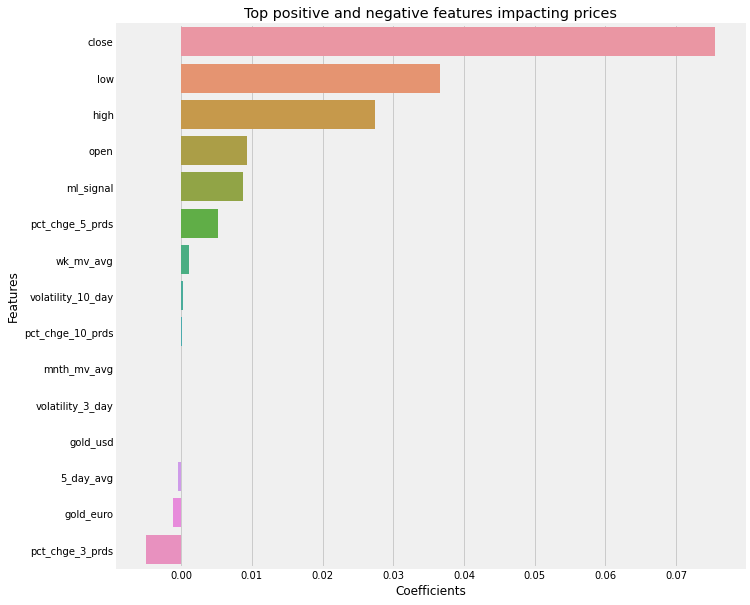

In [96]:
# Plot the graph to show top and bottom features.

f, ax = plt.subplots(figsize=(10,10))
sns.barplot(model_coefs['coef'],model_coefs['feature']);
plt.title("Top positive and negative features impacting prices") 
plt.ylabel("Features")
plt.xlabel("Coefficients") ;

Machine learning signal is an important feature. It is not as important as the prior days pricing.

## 3.7 Create Confusion Matrix

In [97]:
# get predictions
final_res_enet = X_test
final_res_enet['yhat'] = yhat
final_res_enet

,open,high,low,close,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,gold_usd,gold_euro,5_day_avg,ml_signal,yhat
date,,,,,,,,,,,,,,,,
2002-09-23,0.98190,0.98600,0.97540,0.97780,0.978550,0.981250,0.005596,0.005015,0.003790,0.012399,-0.002342,112.1,133.8,0.005940,0,0.986769
2010-04-02,1.35660,1.35810,1.34740,1.35210,1.348760,1.356733,0.003393,0.004644,0.007551,0.011728,-0.001843,390.4,338.6,0.007080,0,1.350224
2016-01-15,1.08830,1.09845,1.08608,1.08960,1.087780,1.089140,0.001291,0.003556,0.003183,-0.000418,0.001361,380.0,407.5,0.005000,0,1.088041
2007-07-04,1.36160,1.36320,1.36080,1.36140,1.355050,1.344100,0.003577,0.002526,0.009491,0.012117,0.014795,227.3,195.9,0.005000,1,1.372850
2016-01-22,1.08342,1.08628,1.07882,1.08110,1.088396,1.088444,0.002859,0.002760,-0.008992,-0.006144,-0.006559,380.9,413.2,0.005000,1,1.097755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-08-03,1.20300,1.20770,1.19960,1.20330,1.205130,1.225683,0.000589,0.002132,-0.002032,-0.006318,-0.027718,135.8,132.2,0.005000,0,1.201452
2009-10-20,1.49730,1.49900,1.48820,1.49230,1.492810,1.474362,0.002185,0.002801,0.000435,0.008127,0.016560,368.9,289.9,0.005580,0,1.491893
2004-12-17,1.32640,1.33410,1.32290,1.33240,1.331500,1.326438,0.004010,0.003616,-0.000414,0.002980,-0.005387,152.5,135.1,0.006720,0,1.330305


In [98]:
# filter columns
final_res_enet.sort_index(inplace=True)
final_res_enet[['open','high','low','close','yhat']].head()

,open,high,low,close,yhat
date,,,,,
2000-08-22,0.9024,0.9035,0.8933,0.8936,0.906124
2000-09-29,0.8813,0.8852,0.8752,0.8828,0.891801
2000-10-13,0.8627,0.8660,0.8530,0.8554,0.864593
2000-10-30,0.8414,0.8530,0.8396,0.8410,0.843707
2000-11-14,0.8593,0.8618,0.8549,0.8588,0.863879


In [99]:
# get result dates
result_dates = final_res_enet.index

In [100]:
prepare_res = features_fr.drop(['mid', 'height-1', 'height-2',
       'height-3','day-1_high','day-1_close','day-1_low','day-1_open',
       'day-2_high', 'day-3_high', 'day-4_high', 'day-2_low',
       'day-3_low', 'day-4_low', 'day-2_open', 'day-3_open',
       'day-4_open', 'day-2_close', 'day-3_close',
       'day-4_close', 'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close',
       'day+2_high', 'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high',
       'day+4_low', 'day+5_high', 'day+5_low', 'fractal_end',
       'day+1_frac', 'day+2_frac', 'day+3_frac', 'day+4_frac', 'select',
       'date+5', 'fractal'], axis=1)

In [101]:
# create the confusion matrix dataframe
create_cm_df = prepare_res.loc[prepare_res.index.isin(result_dates)]
create_cm_df;

In [102]:
# Add predictions
create_cm_df['yhat'] = final_res_enet[['yhat']]
create_cm_df.rename(columns={'exit_price':'threshold','target':'actual_best'}, inplace=True)

In [103]:
def classify_row(row):
    
    if row['direction'] == -1:
        if row['actual_best'] <= row['threshold']:
            return 1
        else:
            return 0
    elif row['direction'] == 1:
        if row['actual_best'] >= row['threshold']:
            return 1
        else:
            return 0

In [104]:
def classify_mlr(row):
    
    if row['direction'] == -1:
        if row['yhat'] <= row['threshold']:
            return 1
        else:
            return 0
    elif row['direction'] == 1:
        if row['yhat'] >= row['threshold']:
            return 1
        else:
            return 0

In [105]:
# classify the outcomes
create_cm_df['correct_decision'] = create_cm_df.apply(classify_row, axis=1)

In [106]:
create_cm_df['ml_decision'] = create_cm_df.apply(classify_mlr, axis=1)

In [107]:
def clasify_cm(row):
    if row['correct_decision'] == 1 and row['ml_decision'] ==1:
        return 'tp'
    elif row['correct_decision'] == 0 and row['ml_decision'] == 0:
        return 'tn'
    elif row['correct_decision'] == 0 and row['ml_decision'] == 1:
        return 'fp'
    elif row['correct_decision'] == 1 and row['ml_decision'] == 0:
        return 'fn'

In [108]:
# check the dataframe
create_cm_df['outcome'] = create_cm_df.apply(clasify_cm, axis=1)
create_cm_df[['open','high','low','close','5_day_avg','threshold','actual_best','ml_signal',
              'yhat','correct_decision','ml_decision','direction','outcome']].head(10)

,open,high,low,close,5_day_avg,threshold,actual_best,ml_signal,yhat,correct_decision,ml_decision,direction,outcome
date,,,,,,,,,,,,,
2000-08-22,0.9024,0.9035,0.8933,0.8936,0.00500,0.89860,0.9075,0,0.906124,1,1,1,tp
2000-09-29,0.8813,0.8852,0.8752,0.8828,0.00500,0.88780,0.8861,0,0.891801,0,1,1,fp
2000-10-13,0.8627,0.8660,0.8530,0.8554,0.00500,0.86040,0.8579,0,0.864593,0,1,1,fp
2000-10-30,0.8414,0.8530,0.8396,0.8410,0.00500,0.83600,0.8388,0,0.843707,0,0,-1,tn
2000-11-14,0.8593,0.8618,0.8549,0.8588,0.00516,0.86396,0.8634,0,0.863879,0,0,1,tn
2001-03-22,0.8965,0.8969,0.8833,0.8872,0.00730,0.89450,0.8993,0,0.891614,1,0,1,fn
2001-04-26,0.8968,0.9050,0.8950,0.9047,0.00764,0.89706,0.8854,-1,0.900296,1,0,-1,fn
2001-06-22,0.8537,0.8605,0.8515,0.8600,0.00500,0.85500,0.8434,-1,0.846041,1,1,-1,tp
2001-09-04,0.9065,0.9066,0.8847,0.8871,0.00920,0.89630,0.9177,1,0.912408,1,1,1,tp


In [109]:
def create_cm(enet_res):
    
    res_cm = [[0,0],
              [0,0]]
    
    for res in enet_res:
        if res == 'tp':
            res_cm[0][0] += 1
        elif res == 'fp':
            res_cm[0][1] += 1
        elif res == 'fn':
            res_cm[1][0] += 1
        elif res == 'tn':
            res_cm[1][1] += 1
    
    return res_cm

In [110]:
cm = create_cm(create_cm_df['outcome'])

In [111]:
cm_df = pd.DataFrame(cm, index=['pred_success', 'pred_non_success'], columns=['actual success', 'actual non_success'])
cm_df

,actual success,actual non_success
pred_success,76,14
pred_non_success,29,34


In [112]:
def print_metrics(cm):
    # Accuracy - how many did the model get right
    # Total number of correct predictions / total number of predictions
    acc= (cm[0][0]+cm[1][1])/(np.sum(cm))
    
    # Precision proportion of positive identifications that were actually correct
    # True positives/ true positives + false positives)
    prec = cm[0][0]/(cm[0][0]+cm[0][1])
    
    # Recall - proportion of actual positives that were correctly defined
    # True positives/ true positives + false negatives
    rec = cm[0][0]/(cm[0][0]+cm[1][0])

    print(f"Accuracy:\t{round(acc,2)}\nPrecision:\t{round(prec,2)}\nRecall:\t\t{round(rec,2)}")


In [113]:
# Display the results
print_metrics(cm)

Accuracy:	0.72
Precision:	0.84
Recall:		0.72
